# Libaries

In [1]:
import wandb
import torch
import math
import requests
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-07-28 17:52:37.966275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 17:52:37.966383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 17:52:38.122387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Wandb

In [3]:
# wandb.login()

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("ImgCap_secretkey")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset

In [5]:
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'

In [6]:
df = pd.read_csv(f'{DATASET_ROOT_PATH}/data.csv')
df.head()

,question,answer,image_id
0,what is on the left side of the white oven on ...,garbage_bin,image1
1,what is on the left side of the fire extinguis...,table,image1
2,what is between the the two white and black ga...,chair,image1
3,how many objects are between the fire extingui...,3,image1
4,what is the largest object in this picture,washing_machine,image1


In [7]:
df.describe()

,question,answer,image_id
count,12468,12468,12468
unique,5886,1443,1447
top,what is on the table,2,image8
freq,248,554,31


# Image Captioning

In [8]:
import os

IMAGE_PATH_ROOT = "/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images"
FOLDER = os.listdir(IMAGE_PATH_ROOT)
FILES = []

for file in FOLDER: 
    FILES.append(f'{IMAGE_PATH_ROOT}/{file}')

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 20
min_length = 10
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "min_length": min_length,
    "num_beams": num_beams,
}

def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

# Q: what is on the left side of the white oven on the floor and on right side of the blue armchair in the image1 ?
# A: garbage_bin

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [9]:
img_caption = dict()
batchs = []

for i in range(0, len(FILES), 256):
    batchs.append(FILES[i:i+256])
print('Batchs = ', len(batchs))

imgcap = []
progress = 0
for batch in batchs: 
    imgcap.append(predict_step(batch))d
    progress += 1
    print(f'Progress: {progress}/{len(batchs)}')

Batchs =  6


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Progress: 1/6
Progress: 2/6
Progress: 3/6
Progress: 4/6
Progress: 5/6
Progress: 6/6


In [10]:
img_cap = [i for batch in imgcap for i in batch]
print(len(img_cap))

print(img_cap[:10])

1449
['a living room filled with furniture and a tv', 'a living room filled with furniture and a window', 'a kitchen with a table, chairs and a refrigerator', 'a kitchen with a cat sitting on the counter', 'a kitchen with a table and chairs and a window', 'a classroom filled with desks and a computer', 'a living room filled with chairs and tables', 'a living room filled with furniture and a couch', 'a living room filled with furniture and a couch', 'a living room filled with furniture and a computer']



 image1317:  a living room filled with furniture and a tv


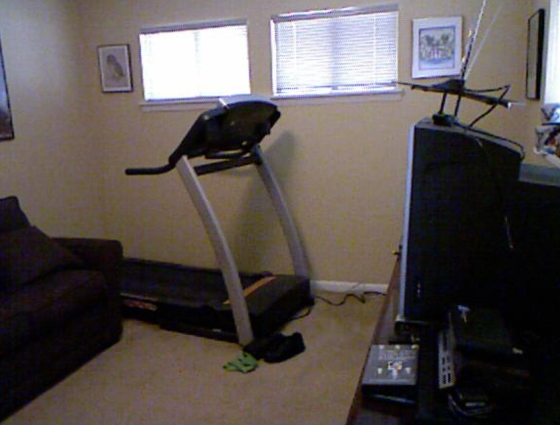


 image1268:  a living room filled with furniture and a window


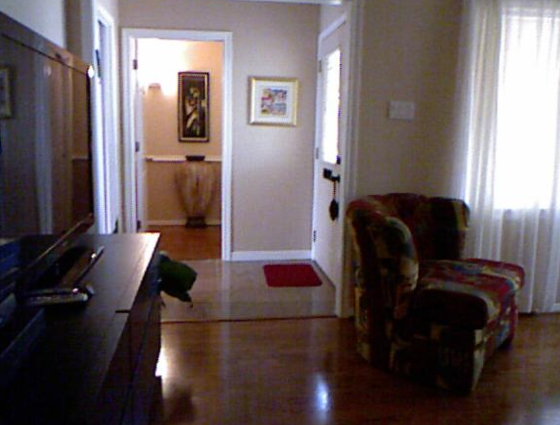


 image745:  a kitchen with a table, chairs and a refrigerator


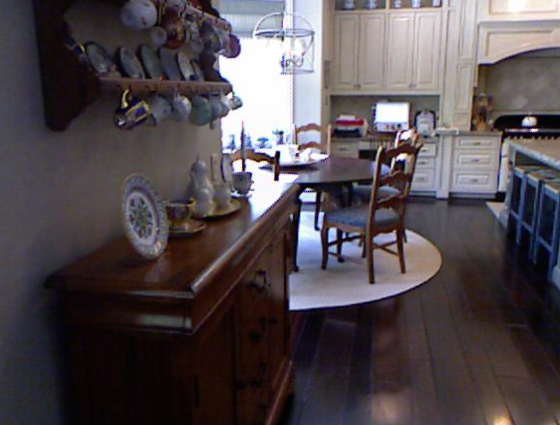

In [11]:
from IPython.display import display

name_file = [i.split('.')[0] for i in FOLDER]
imgcap_dict = dict(zip(name_file, img_cap))

count = 0
for key, item in imgcap_dict.items():
    print(f'\n {key}:  {item}')
    im = Image.open(f'{IMAGE_PATH_ROOT}/{key}.png')
    display(im)  # use IPython.display to show the image in the notebook
    count += 1
    if count == 3: break

In [12]:
vocabulary_ic = set(' '.join(img_cap).replace(',', '').split())
len(vocabulary_ic)

281

# Create Data Sample

In [13]:
def create_data_sample(path, imgcap_dict):
    df = pd.read_csv(path)
    
    questions = df['question'].tolist()
    answers = df['answer'].tolist()
    images = df['image_id'].tolist()

    data_sample = []

    for question, answer, image in zip(questions, answers, images):
        answer_choices = answer.split(', ')
        sample = {
            'question': question,
            'answer': answer_choices[0],
            'image_id': image,
            'ic': imgcap_dict[image]
        }
        data_sample.append(sample)

    return data_sample

all_data = create_data_sample(f'{DATASET_ROOT_PATH}/data.csv', imgcap_dict)
train_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_train.csv', imgcap_dict)
test_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_eval.csv', imgcap_dict)

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

vocab = tokenizer.get_vocab()
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")
print(list(vocab.keys())[:10])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Vocab size: 30522
['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']


In [15]:
def tokenize(question, max_seq_len):
    # Sử dụng phương thức encode của tokenizer
    tokens = tokenizer.encode(
        question,
        add_special_tokens=True,  # Thêm [CLS] và [SEP]
        max_length=max_seq_len,
        padding='max_length',     # Padding đến max_seq_len
        truncation=True           # Cắt bớt nếu quá dài
    )
    return tokens

print(tokenize(all_data[0]['question'], max_seq_len=30))

[101, 2054, 2003, 2006, 1996, 2187, 2217, 1997, 1996, 2317, 17428, 2006, 1996, 2723, 1998, 2006, 2157, 2217, 1997, 1996, 2630, 29372, 102, 0, 0, 0, 0, 0, 0, 0]


In [16]:
ANSWER_SPACE_PATH = f'{DATASET_ROOT_PATH}/answer_space.txt'
with open(ANSWER_SPACE_PATH, 'r') as f:
    data = f.read()
    classes = data.split('\n')
    n_classes = len(classes)

    classes_to_idx = {
        cls_name: idx for idx, cls_name in enumerate(classes)
    }

    idx_to_classes = {
        idx: cls_name for idx, cls_name in enumerate(classes)
    }

In [17]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len = 30,
        transform = None,
        root_dir = f'{DATASET_ROOT_PATH}/images'
    ):
        self.data = data
        self.classes_to_idx = classes_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(
            self.root_dir,
            self.data[index]['image_id'] + '.png'
        )
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        answer = self.data[index]['answer']
        answer = self.classes_to_idx[answer]
        answer = torch.tensor(answer, dtype=torch.long)
        
        imgcap = self.data[index]['ic']
        imgcap = tokenize(imgcap, self.max_seq_len)
        imgcap = torch.tensor(imgcap, dtype=torch.long)

        return img, question, answer, imgcap

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

transform2visual = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = VQADataset(train_data[:int(0.9*len(train_data))], classes_to_idx, transform=transform)
val_dataset = VQADataset(train_data[int(0.9*len(train_data)):], classes_to_idx, transform=transform)
test_dataset = VQADataset(test_data, classes_to_idx, transform=transform)
test_dataset_visual = VQADataset(test_data, classes_to_idx, transform=transform2visual)

train_batch_size = 16
val_batch_size = 16
test_batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

test_loader_visual = torch.utils.data.DataLoader(
    test_dataset_visual,
    batch_size=test_batch_size,
    shuffle=False,
)

# Language Channel

In [19]:
class LanguageChannel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained("bert-base-uncased")
        # Freeze BERT model
        for param in self.model.parameters():
            param.requires_grad = False
            
        self.fc = nn.Linear(768, 1024)

    def forward(self, encoded_input):
        with torch.no_grad():
            output = self.model(encoded_input)
            
        output = self.fc(output.last_hidden_state[:, 0, :])
        return output

In [20]:
# vocab_size = len(vocab)

bert = LanguageChannel()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Vision Channel

In [21]:
# Dùng mô hình Pretrained
resnet = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Thay thế lớp fully connected
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1024),
    nn.ReLU(),
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.1MB/s]


# Multilayer Perceptron


In [22]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, k_class):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_units, k_class)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x

In [23]:
input_dim = 2048
hidden_units = 1024
k_class = n_classes

mlp = MLP(input_dim, hidden_units, k_class)

# Model

In [24]:
class Bert_ResNet_MLP(nn.Module):
  def __init__(self, language_model, vision_model, mlp):
    super().__init__()

    self.language_channel = language_model
    self.vision_channel = vision_model
    self.mlp = mlp

  def forward(self, image, text, ic):
    question_embedding = self.language_channel(text)
    image_embedding = self.vision_channel(image)
    imgcap_embedding = image_embedding.clone()

    if ic is not None:
        caption_embedding = self.language_channel(ic)
        imgcap_embedding = image_embedding + imgcap_embedding
        
    combined_embedding = torch.cat((question_embedding, imgcap_embedding), dim=1)
    distribution = self.mlp(combined_embedding)

    return distribution

In [25]:
bert = bert.to(device)
resnet = resnet.to(device)
mlp = mlp.to(device)

model = Bert_ResNet_MLP(bert, resnet, mlp)
model = model.to(device)

batch_size = 2
dummy_image = torch.randn((batch_size, 3, 244, 244), dtype=torch.float)
dummy_question = torch.randint(0, vocab_size, (batch_size, 30), dtype=torch.long)
dummy_imgcap = torch.randint(0, vocab_size, (batch_size, 30), dtype=torch.long)

# Chuyển dữ liệu sang thiết bị (device)
dummy_image = dummy_image.to(device)
dummy_question = dummy_question.to(device)
dummy_imgcap = dummy_imgcap.to(device)

# Gọi hàm summary
summary(model, input_data=[dummy_image, dummy_question, dummy_imgcap])

Layer (type:depth-idx)                                            Output Shape              Param #
Bert_ResNet_MLP                                                   [2, 582]                  --
├─LanguageChannel: 1-1                                            [2, 1024]                 --
│    └─BertModel: 2-1                                             [2, 768]                  --
│    │    └─BertEmbeddings: 3-1                                   [2, 30, 768]              (23,837,184)
│    │    └─BertEncoder: 3-2                                      [2, 30, 768]              (85,054,464)
│    │    └─BertPooler: 3-3                                       [2, 768]                  (590,592)
│    └─Linear: 2-2                                                [2, 1024]                 787,456
├─ResNet: 1-2                                                     [2, 1024]                 --
│    └─Conv2d: 2-3                                                [2, 64, 122, 122]         9,408
│    └─Bat

# Training

In [26]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs in val_loader:
            images, questions, answers, imgcaps = inputs
            
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)
            imgcaps = imgcaps.to(device)
            
            outputs = model(images, questions, None)
            
            loss = criterion(outputs, answers)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += answers.size(0)
            correct += (predicted == answers).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [27]:
from tqdm import tqdm
import time


def model_fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs,
    device
):
    wandb.init(project='ImgCap_VQA_Transformer_ResNet34', config={
        "epochs": EPOCHS,
        "batch_size": train_loader.batch_size,
        "optimizer": optimizer.__class__.__name__,
#         "scheduler": scheduler.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr'],
    })
    
    # Sử dụng DataParallel để sử dụng nhiều GPU
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)
    
    # Chuyển mô hình vào GPU
    model.to(device)
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    early_stopping = 5
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'
    
    for epoch in range(epochs):
        batch_train_losses = []
        train_correct = 0
        train_total = 0

        # Sử dụng tqdm để hiển thị thanh tiến trình
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for idx, inputs in enumerate(train_loader):
                model.train()
                images, questions, answers, imgcaps = inputs
                images = images.to(device)
                questions = questions.to(device)
                answers = answers.to(device)
                imgcaps = imgcaps.to(device)

                optimizer.zero_grad()
                outputs = model(images, questions, imgcaps)
                loss = criterion(outputs, answers)

                _, predicted = torch.max(outputs.data, 1)

                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()

                loss.backward()
                optimizer.step()

                step_train_loss = loss.item()
                batch_train_losses.append(step_train_loss)

                pbar.set_postfix({
                    'train_loss': step_train_loss,
                    'train_acc': train_correct / train_total
                })
                pbar.update()
                
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        if val_losses: 
            if val_loss > best_val_loss:
                early_stopping -= 1
            else:
                early_stopping = 5
                
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Ghi log vào Wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })
        
        print(f'Train Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')
#         scheduler.step()
        
        # Lưu lại mô hình mỗi n epoch
        if (epoch + 1) % 5 == 0:
            model_save_path = f'model_epoch_{epoch + 1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, model_save_path)
            print(f'Model saved to {model_save_path}')
        
        # Lưu lại mô hình với trọng số tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path)
        
        # Early Stopping
        if early_stopping < 1:
            break

    return train_losses, val_losses, train_accs, val_accs

In [28]:
LR = 1e-5
EPOCHS = 100
WEIGHT_DECAY = 1e-5

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# total_steps = len(train_loader) * EPOCHS
# warmup_steps = int(total_steps * 0.1)

# scheduler = get_linear_schedule_with_warmup(
#     optimizer, 
#     num_warmup_steps=warmup_steps, 
#     num_training_steps=total_steps
# )
scheduler = None

In [ ]:
train_losses, val_losses, train_accs, val_accs = model_fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    EPOCHS,
    device
)

wandb: Currently logged in as: devkoi2k3. Use `wandb login --relogin` to force relogin


Using 2 GPUs!


Epoch 1/100:  45%|████▍     | 251/561 [01:57<02:18,  2.23batch/s, train_loss=5, train_acc=0.0406]   

In [ ]:
torch.save(model.state_dict(), 'ImgCap_Bert_ResNet34_100e_weights.pth')

# Evaluating

In [ ]:
# import torch
# model = model

# # Tải lại trọng số của mô hình
# checkpoint = torch.load('/kaggle/input/vqa_bilstm_resnet18/pytorch/vqa_lstm_resnet18/1/LSTM_ResNet18_200e_weights.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
# model.load_state_dict(checkpoint)

# model.eval()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# print("Model loaded successfully.")


In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')


In [ ]:
images, questions, labels = next(iter(test_loader_visual))
question_list = [test_data[i]['question'] for i in range(len(test_data))]

images = images.to(device)
questions = questions.to(device)

model.eval()

with torch.no_grad():
    outputs = model(images, questions, None)
    _, preds = torch.max(outputs, 1)

for i in range(20):
    img = images[i].cpu().numpy().transpose(1, 2, 0) 
    
    plt.imshow(img)
    plt.title(f"Question: {question_list[i]}\nPrediction: {idx_to_classes[preds[i].item()]}")
    plt.show()